Introduction à Pytorch Lightning: Gestion des données et apprentissage
======

L'objectif de ce TP est de se familiariser  avec la librairie PyTorch Lightning en réalisant un réseau de neurones capable de classifier des vêtements. Il sera à réaliser en python 3. Les librairies utilisées sont installées sur les machines de l'université, vous pouvez néanmoins les installer sur vos propres machines à l'aide de l'utilitaire `pip` présent par défaut avec python.
	
N'hésitez pas à regarder régulièrement la documentation de ces librairies, des exemples d'utilisation accompagnent généralement l'explication de chaque fonction.

Langage utilisé:
- Python 3: https://docs.python.org/3/

Librairie d'affichage de données:
- Matplotilb: https://matplotlib.org/contents.html

Librairie de Deep Learning
- PyTorch: https://pytorch.org/docs/stable/index.html
- PyTorch Lightning: https://pytorch-lightning.readthedocs.io/en/stable/
- Torchvision: https://pytorch.org/vision/stable/index.html
- Torchmetrics: https://torchmetrics.readthedocs.io/en/stable/


In [1]:
# Import torch
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset



# Import lightning
import lightning as L
from lightning import Trainer
from lightning.pytorch.utilities.types import STEP_OUTPUT

# import torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data.dataset import random_split
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

# import torchmetrics
from torchmetrics import Accuracy

# Autres import 
import timm 

from typing import Dict, Iterator, List, Optional, Tuple, TypeVar

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
L.__version__

'2.2.2'

# Quelques rappels

1 - Introduction au notebook jupyter
----------

Exécutez la ligne suivante en vous plaçant dans la cellule et en appuyant sur *Ctrl+Entrée*.

In [3]:
a=1
print(a)

1


Lancez la ligne suivante plusieurs fois. 

In [4]:
a += 1
print(a)

2


Relancez le premier bloc définissant la variable `a` puis lancez le bloc suivant (remarquez bien les valeurs après In [\*] ):

In [5]:
print(a)

2


Vous pouvez utiliser l'aide à la complétion avec tab. Testez avec la fonction torch.randn.

In [6]:
torch.randn(3)

tensor([-0.3305,  1.2682,  0.5798])

Vous pouvez accéder à la documentation de la fonction avec *Shit+tab*. Testez avec la fonction torch.randn.

In [7]:
torch.randn(4, 2)

tensor([[ 0.2438,  0.3133],
        [-0.4955, -0.8113],
        [-0.8340, -1.1096],
        [-0.8550, -0.1634]])

2 - Visualisation des données (Matplotlib)<a id="title1.3"></a> 
-----

`Matplotlib` permet de construire une figure à visualiser. La création d'une figure ce fait à l'aide de l'instruction `plt.figure`. Toutes les instructions que l'on fait ensuite agissent sur la figure courante en mémoire mais ne sont pas directement visibles. Afin de rendre effectivement visible la figure finale, on utilise l'instruction `plt.show`. Cette instruction est bloquante en python standard. 
Testez le code suivant affichant un `sinus` et un `cosinus`.

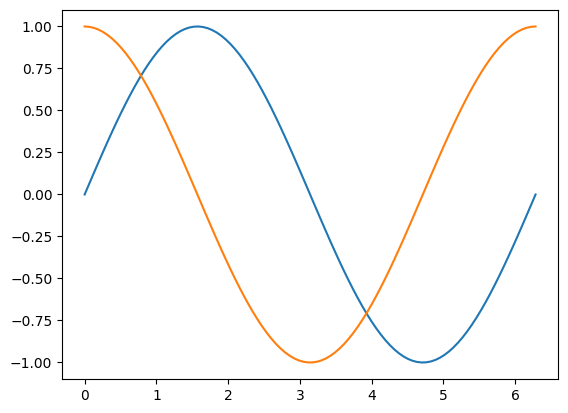

In [8]:
x = torch.linspace(0,2*torch.pi,100) # création de 100 points entre 0 et 2pi
plt.figure() # Création d'une figure
plt.plot(x,torch.sin(x)) # Ajout du tracé d'un sinus composé de 100 points reliés par des droites entre 0 et 2pi
plt.plot(x,torch.cos(x)) # Ajout du tracé d'un cosinus composé de 100 points reliés par des droites entre 0 et 2pi
plt.show() # Affichage de la figure créée.

La fonction `plt.imshow` permet d'afficher un tableau comme une image. Les valeurs doivent être soit entières entre 0 et 255 soit flottantes entre 0. et 1. .

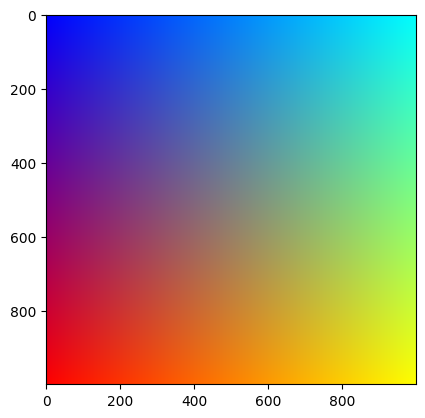

In [9]:
n=int(1e3)
x = torch.linspace(0,1,n)
degradee = torch.tile(x[:,None],(n,))
im = torch.stack((degradee,degradee.T,1-degradee),axis=2)

plt.figure()
plt.imshow(im)
plt.show()

Si le tableau est une matrice, l'image sera affichée en fausse couleurs correspondant à la carte de couleur paramétrée. Pour avoir une image en noir et blanc, il faudra préciser `cmap='gray'`.

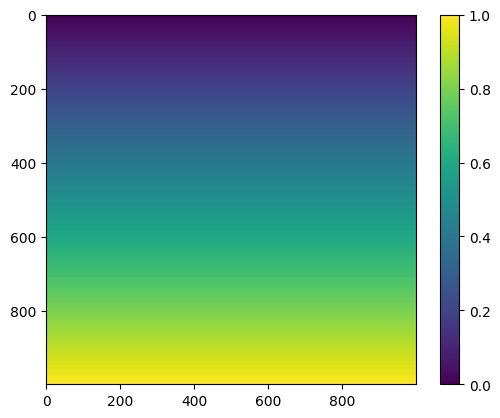

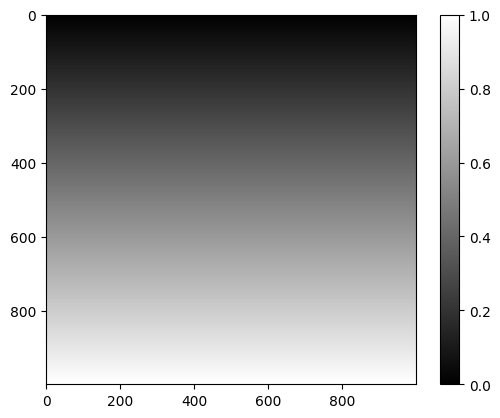

In [10]:
plt.figure()
plt.imshow(degradee)
plt.colorbar()

plt.figure()
plt.imshow(degradee,cmap='gray')
plt.colorbar()

plt.show()


Il est également possible d'afficher une image en la convertissant en image PIL avec `torchvision.transforms.functional.to_pil_image` puis en utilisant la méthode `display` de jupyter.

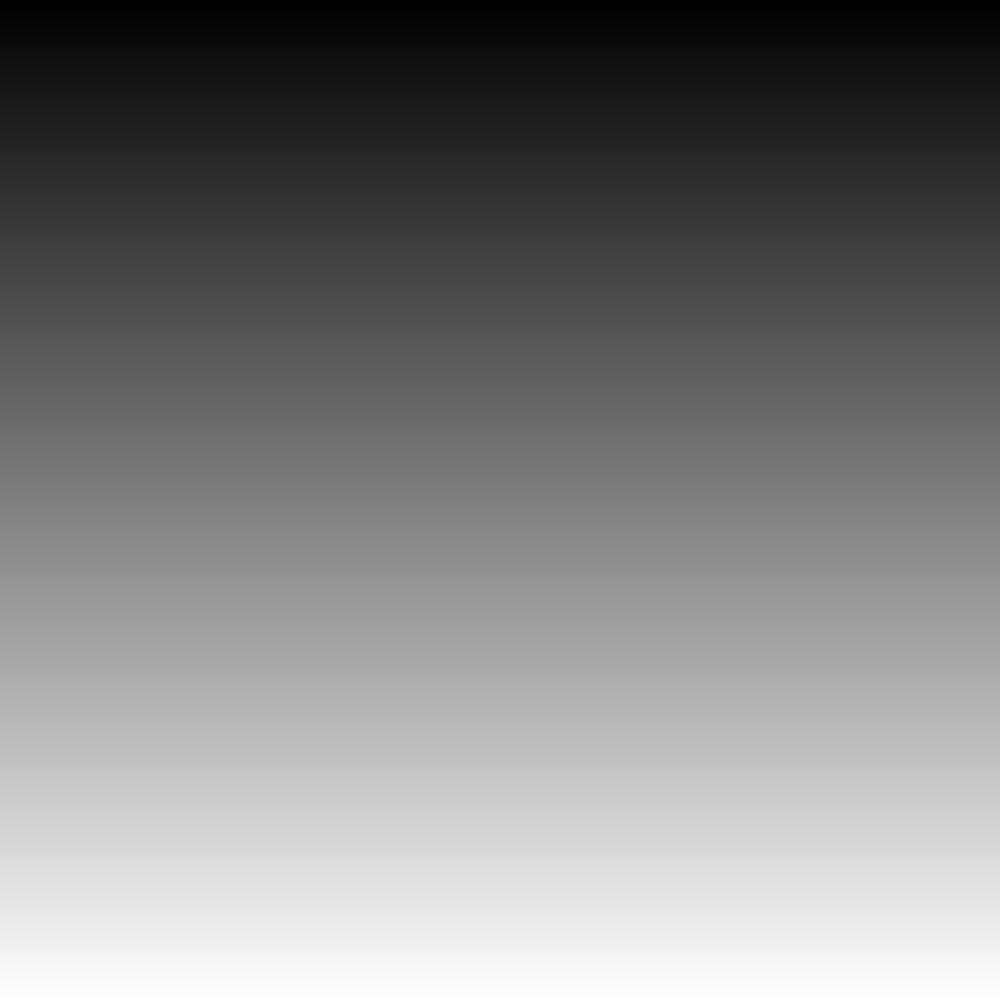

In [11]:
display(torchvision.transforms.functional.to_pil_image(degradee))

# Sujet du TP

Ce TP se décompose en 4 étapes qui seront détaillées dans les parties suivantes:
1. Préparation de la base de données étudiée et des batches en créant la classe `MyDataModule` qui hérite de `L.LightningDataModule`.
2. Instansation d'un modèle de réseau de neurones et implémentation des méthodes nécessaires pour l’entraîner en créant la classe `MyModel` qui hérite de `L.LightningModule`.
3. Entraîner le modèle de l'étape 2 à l’aide des données préparées dans l’étape 1.
4. Evaluation du modèle sur des données de test.

# 1- Création d'un LigthningDataModule

Nous allons dans ce TP travailler sur une sous-partie du dataset [Fashion-Mnist](https://github.com/zalandoresearch/fashion-mnist) composé de petite imagenette de vêtements. 

Afin de gérer ce dataset, nous allons implémenter une classe `MyDataModule` héritant de [L.LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html).

Nous allons créer cette classe progressivement dans la suite du TP. Vous reviendriez modifier le bloc suivant au cours des différentes étapes décrites par la suite. 

Commencez par créer la classe `MyDataModule` héritant de `L.LightningDataModule`. Vous déclarez un constructeur prenant et enregistrant les paramètres suivants: 
- un nom de dossier où est sauvegardé la base de donnée (./data par défaut),
- la taille des batches (64 images par défaut),
- la proportion du trainset à utiliser pour la validation (10\% par défaut). 

In [109]:
from torch.utils.data import Subset

class MyDataModule(L.LightningDataModule):
    def __init__(self,
    data_dir:str='./data',
    batch_size:int=64,
    seed:int=42,
    size_val:float=0.1
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed
        self.size_val = size_val

    def prepare_data(self):
        FashionMNIST(self.data_dir, train=True, download=True)
        FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None) -> None:
        # if stage == "test" or stage is None:
        transform_test = transforms.Compose([transforms.ToTensor()])
        self.data_test = FashionMNIST(
            self.data_dir, train=False, download=False, transform=transform_test
        )
        indices = torch.where((self.data_test.targets == 0) | (self.data_test.targets == 1))[0]
        self.data_test = Subset(self.data_test, indices)
        # if stage == "fit" or stage is None:
        transform_train = transforms.Compose([transforms.ToTensor()])
        data_full = FashionMNIST(
            self.data_dir, train=True, download=False, transform=transform_train
        )
        indices = torch.where((data_full.targets == 0) | (data_full.targets == 1))[0]
        data_full = Subset(data_full, indices)
        self.data_train, self.data_val = torch.utils.data.random_split(
            data_full,
            [len(data_full)-int(len(data_full)*self.size_val),
            int(len(data_full)*self.size_val)],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.data_train, batch_size=self.batch_size,
        shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.data_val, batch_size=self.batch_size,
        shuffle=True)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.data_test, batch_size=self.batch_size,
        shuffle=False)

    def predict_dataloader(self) -> DataLoader:
        return DataLoader(self.data_test, batch_size=self.batch_size,
        shuffle=False)
    


In [110]:
# Relancez ce code à chaque modification du bloc précédant
datamodule = MyDataModule()

Ajoutez une méthode `prepare_data`. Cette méthode permet la préparation des données. Dans notre cas, elle téléchargera la base de données si nécessaire et la placera dans le dossier indiqué dans l'attribut `data_dir` de la classe. Vous utiliserez pour réaliser cette fonction la classe [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) de `torchvision` avec l'attribut `download`à *True*.

Vérifiez que l'appel de la méthode permet bien le téléchargement de la base de donnée dans le dossier prévu à cet effet.

In [111]:
datamodule.prepare_data()

In [112]:
ls {datamodule.data_dirmax_epochs = 10}

ls: impossible d'accéder à '{datamodule.data_dirmax_epochs': Aucun fichier ou dossier de ce nom
ls: impossible d'accéder à '=': Aucun fichier ou dossier de ce nom
ls: impossible d'accéder à '10}': Aucun fichier ou dossier de ce nom


Ajoutez une méthode `setup`. Cette méthode permet de définir des [Datasets Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Pour cela, vous utiliserez à nouveau la classe `FashionMnist`, mais avec l'attribut `download` à *false*. 

Définissez 
- `self.data_train`: correspondant aux images d'apprentissage du dataset FashionMnist
- `self.data_test`: correspondant aux images de test du dataset FashionMnist

Appelez la méthode `setup` sans argument. Cette méthode ne retourne rien, mais vous pouvez vérifier ensuite la taille des datasets stocker dans les attributs dédiés.

In [113]:
datamodule.setup()
print('Taille de train:',len(datamodule.data_train))
print('Taille de test:',len(datamodule.data_test))

Taille de train: 10800
Taille de test: 2000


En utilisant la fonction `display`, affichez la première image de `train` et de `test`. Attention, `data_train` et `data_test` contiennent les images et les labels.

In [114]:
# display(datamodule.data_train[0][0])
# display(datamodule.data_test[0][0])

Notre dataset retourne actuellement des images au format PIL qui ne peuvent pas être exploité par un réseau de neurones. En intégrant la transformation `torchvision.transforms.ToTensor()` dans le constructeur de `FashionMnist`, convertissez les images en tableau torch. Si vous relancez, l'affichage de la question précédente vous devez avoir des tableaux de valeurs et plus des images.

In [115]:
display(transforms.functional.to_pil_image(datamodule.data_train[0][0]))
display(transforms.functional.to_pil_image(datamodule.data_test[0][0]))

Afin d'accélérer les calculs, nous allons restreinte la base aux deux premières classes (T-Shirt et pantalon). En utlisant `torch.utils.data.Subset` limitez `data_train` et `data_test` aux exemples dont le label est 0 ou 1. Pour faire cette question, vous pouvez utliser l'attribut `targets` des objets de la classe FashionMnist et la méthode `torch.where` ou `torch.argwhere`. Vérifiez que le nombre d'exemple a bien diminué. 

In [116]:
datamodule.setup()
print('Taille de train:',len(datamodule.data_train))
print('Taille de test:',len(datamodule.data_test))

Taille de train: 10800
Taille de test: 2000


Nous allons maintenant découper l'ensemble d'apprentissage en deux ensembles `data_train` et `data_val`. On utilisera la proportion renseigné dans le constructeur pour faire la répartition à l'aide de la fonction [random_split](https://pytorch.org/docs/stable/data.html). Vérifiez que les dimensions sont correcte.

In [117]:
datamodule.setup()
print('Taille de train:',len(datamodule.data_train))
print('Taille de val:',len(datamodule.data_val))
print('Taille de test:',len(datamodule.data_test))

Taille de train: 10800
Taille de val: 1200
Taille de test: 2000


Écrivez la méthode `train_dataloader`. Cette méthode retourne un dataloader pytorch sur les données de `train`. Vous pourrez utiliser la classe [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) avec les arguments appropriés. 

Vérifiez le bon fonctionnement de votre méthode en affichant toutes les images du premier batch avec `display`. Vous pourrez utiliser les méthodes `iter` et `next` pour récupérer uniquement le premier batch et la méthode `torchvision.utils.make_grid` pour convertir le batch en une grille d'images. 


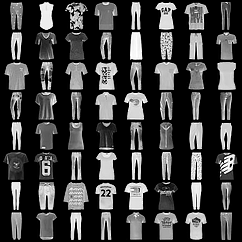

In [118]:
train_dataloader = datamodule.train_dataloader()
train_dataloader
first_batch = None

first_batch = next(iter(train_dataloader))

# first_batch
# for data in first_batch[0]:
#     # display(transforms.functional.to_pil_image(data[0]))
#     display(transforms.functional.to_pil_image(data))
display(transforms.functional.to_pil_image(torchvision.utils.make_grid(first_batch[0])))


Faites de même pour les méthodes:
- `val_dataloader` : renvoye un `DataLoader` sur les données de validation,
- `test_dataloader` : renvoye un `DataLoader` sur les données de test,

Val:


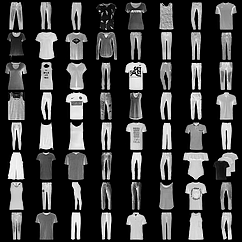

Test:


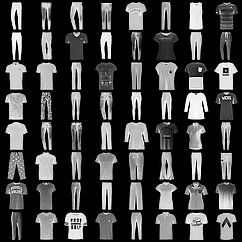

In [119]:
dataloader = datamodule.val_dataloader()
first_batch = None

first_batch = next(iter(dataloader))

# first_batch
# for data in first_batch[0]:
#     # display(transforms.functional.to_pil_image(data[0]))
#     display(transforms.functional.to_pil_image(data))
print("Val:")
display(transforms.functional.to_pil_image(torchvision.utils.make_grid(first_batch[0])))

dataloader = datamodule.test_dataloader()
first_batch = None

first_batch = next(iter(dataloader))

# first_batch
# for data in first_batch[0]:
#     # display(transforms.functional.to_pil_image(data[0]))
#     display(transforms.functional.to_pil_image(data))
print("Test:")
display(transforms.functional.to_pil_image(torchvision.utils.make_grid(first_batch[0])))

# 2- Mise en place du réseau de neurone

Nous allons dans cette partie construire le modèle en utilisant le même principe que la partie précédente. 

Commencez par créer la classe `MyModel` héritant de [L.LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). Vous définirez un constructeur prenant les arguments suivant: 
- lr: le *learning rate*,
- weight_decay: le poids de la régularisation,
- num_class: le nombre de classe (ici 2),
- *args : d'autres arguments non nommés,
- **kwargs: : d'autres arguments nommés. 

Dans ce constructeur, vous effectuerez les étapes suivantes: 
- sauvegarde des paramètres d'entrées en utilisant `save_hyperparameters`.
- définition d'un réseau de type `resnet18` que vous prendrerez pré-entrainé pour une tâche de classification de type ImageNet à partir de la librairie `timm`. Vous utiliserez `timm.create_model` avec `pretrained`, `in_chans` et `num_classes` correctement rempli.
- Définissez une fonction de coût de type `nn.CrossEntropyLoss` pour train, val et test. 
- Définissez une métrique d'évaluation de type `Accuracy` pour val et test. 

In [120]:
class MyModel(L.LightningModule):
    def __init__(self,
        lr:float=0.1,
        weight_decay:float=1e-4,
        num_class:int=2,
        *args,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model(
            'resnet18',
            pretrained=True,
            in_chans=1,
            num_classes=self.hparams.num_class
        )
        self.loss_train = nn.CrossEntropyLoss()
        self.loss_valid = nn.CrossEntropyLoss()
        self.loss_test = nn.CrossEntropyLoss()

        self.valid_acc = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        self.test_acc = Accuracy(task="multiclass", num_classes=self.hparams.num_class)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        vloss = self.loss_train(y_hat, y)

        # self.log("performance", {"acc": self.training_acc})

        self.log("train_loss", vloss)
        
        return vloss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        self.valid_acc(preds, y)
        self.log('val_acc', self.valid_acc)
        # print('val_acc', self.valid_acc)

    
    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        self.test_acc(preds, y)
        self.log('test_acc', self.test_acc)
        # print('test_acc', self.test_acc)

    def predict_step(self, batch, batch_idx):
        
        x, y = batch
        y_pred= self(x)
        return y_pred.softmax(dim=-1)
        # print('test_acc', self.test_acc)

        

    def configure_optimizers(self):
        self.optim_algo = torch.optim.Adam(self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        return self.optim_algo

In [121]:
# Création d'un objet MyModel. A relancer à chaque modification de MyModel.
model = MyModel()

Définissez une méthode `forward` qui calcule la sortie du réseau en fonction de son entrée. Testez votre méthode avec un tableau aléatoire de taille $(8,1,28,28)$. Vous pouvez utiliser la fonction [torch.rand](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [122]:
m = model
# single channel image
x = torch.randn(8, 1, 28, 28)
display(m(x).shape)

torch.Size([8, 2])

Définissez la méthode `training_step`. Cette méthode calcul la sortie du réseau pour un batch donné puis évalue la fonction de coût (qu'elle retournera). Vous effectuerez également les logs de la fonction de coût.  

Récupérez le premier batch avec le `datamodule` de la première partie et testez votre fonction. Le deuxième paramètre sera mis à 0 pour ce test.

Vérifiez que votre fonction retourne bien une valeur pour la loss.

In [123]:
dataloader = datamodule.train_dataloader()

first_batch = None

first_batch = next(iter(dataloader))


model.training_step(first_batch, 0)


tensor(0.9593, grad_fn=<NllLossBackward0>)

Définissez la méthode `validation_step` effectuant le traitement d'un batch sur les données de validation. Cette méthode est très similaire à la précédente hormis le fait qu'elle ne retourne rien et log en plus les performances en *accuracy*.

Testez la méthode en la lançant. Il ne devrait rien s'afficher, mais vous ne devez pas avoir d'erreur. 

In [124]:
dataloader = datamodule.val_dataloader()

first_batch = None

first_batch = next(iter(dataloader))


model.validation_step(first_batch, 0)

Définissez de la même manière que précédemment la méthode `test_step`.

In [125]:
dataloader = datamodule.test_dataloader()

first_batch = None

first_batch = next(iter(dataloader))


model.test_step(first_batch, 0)

Définissez la méthode `configure_optimizers` qui retourne le ou les optimiseurs choisis pour entrainer le réseau. Nous utiliserons ici un optimiser d'[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

Lancez votre méthode pour en vérifier le bon fonctionnement.

In [126]:
model.configure_optimizers()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0.0001
)

# 3- Entraînement du modèle 

Nous avons précédemment défini tous les éléments important pour apprendre notre réseau. 
En utilisant un objet de type [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html), faites un apprentissage sur 2 époques (vous pouvez faire plus d'époque pour de meilleurs résultats).

In [127]:
trainer = Trainer(max_epochs = 2)

trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | model      | ResNet             | 11.2 M
1 | loss_train | CrossEntropyLoss   | 0     
2 | loss_valid | CrossEntropyLoss   | 0     
3 | loss_test  | CrossEntropyLoss   | 0     
4 | valid_acc  | MulticlassAccuracy | 0     
5 | test_acc   | MulticlassAccuracy | 0     
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.685    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


# 4- Evaluation du modèle appris

En utilisant la méthode `test` du `Trainer` précédent, obtenez les performances sur la base de test.

In [128]:
trainer.test(model, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6971899271011353     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.6971899271011353}]

Modifiez `MyDataModule` et `MyModel` pour effectuer des prédictions sur la base de test à l'aide `trainer.predict`. Les labels prédits vous paraisses-t-il corrects ?  

In [129]:
y = FashionMNIST(
            './data', train=False, download=False
        ).targets

y[y<2]

tensor([1, 1, 1,  ..., 1, 1, 1])

In [130]:
# timm.list_models()

In [131]:
torch.argmax(trainer.predict(model, datamodule)[0],1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                             | 0/? [00:00<?, ?it/s]

tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])